<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [51]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [54]:
data['datetime'].is_monotonic #проверка на соблюдение очередности

True

In [55]:
data = data.set_index('datetime') # устанавливаем индекс

In [56]:
data.sort_index(inplace=True) #сортируем (в данном случае у нас порядок соблюден, но пусть будет)

In [57]:
data = data.resample('1H').sum() #ресемплирование по одному часу

In [58]:
data.head(5) 

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Нам предоставлен датафрейм, содержащий 26496 наблюдений и два признака (количество заказов и время). В процессе ознакомпления:
* установили 'datetime' в качестве индекса
* отсортировали по возрастанию временного ряда
* провели ресемплирование (группирование) данных а рамках одного часа

## Анализ

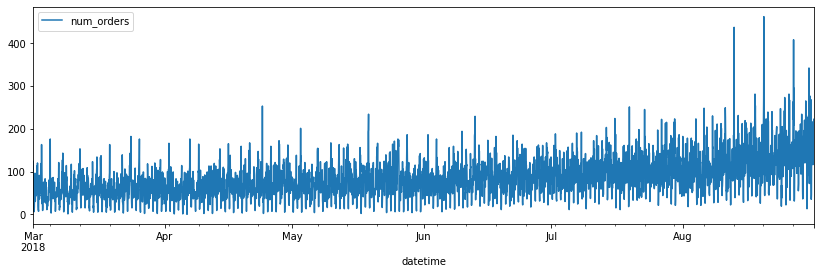

In [59]:
data.plot(figsize=(14,4));

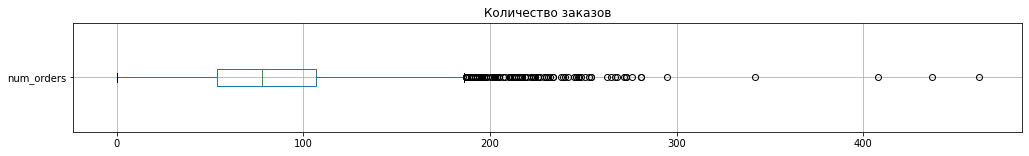

In [60]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data.boxplot(vert = False, ax =ax)
ax.set_title('Количество заказов');

In [61]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [62]:
data.query('num_orders > 300')

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


У нас имеется 4416 наблюдений. Среднее количество заказов в час 84.42, медиана - 78.0, стандартное отклонение 45.02. На диаграмме размаха заметны выбросы, часы, когда количество заказов превышало 300. Все эти выбросы приходятся на вторую часть августа, и попадут в тестовую выборку. Именно поэтому  мы их удалять не будем, сравним с предсказанными данными.

**Скользящее среднее**

Для анализа представленных данных проведем ресемплирование (группирование) данных в рамках суток.

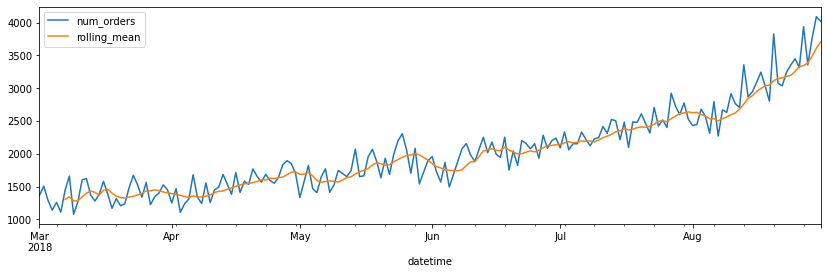

In [63]:
data_day = data.resample('1D').sum()
data_day['rolling_mean'] = data_day.rolling(7).mean() 
data_day.plot(figsize=(14, 4));

Скользящее среднее показывает среднее значение цены инструмента (количество заказов) за некоторый период времени (окно). Так как расчет производится на данных, ресемплированных на один день, диапазон расчета скользящего среднего (окно) установили 7 дней. Такие параметры позволяют посмотреть усредненные данные за "скользящую" неделю.

По графику можно отметить постепенный рост количества заказов, который усиливается в конце августа.

**Тренды и сезонность**

In [64]:
decomposed = seasonal_decompose(data.resample('1D').sum())

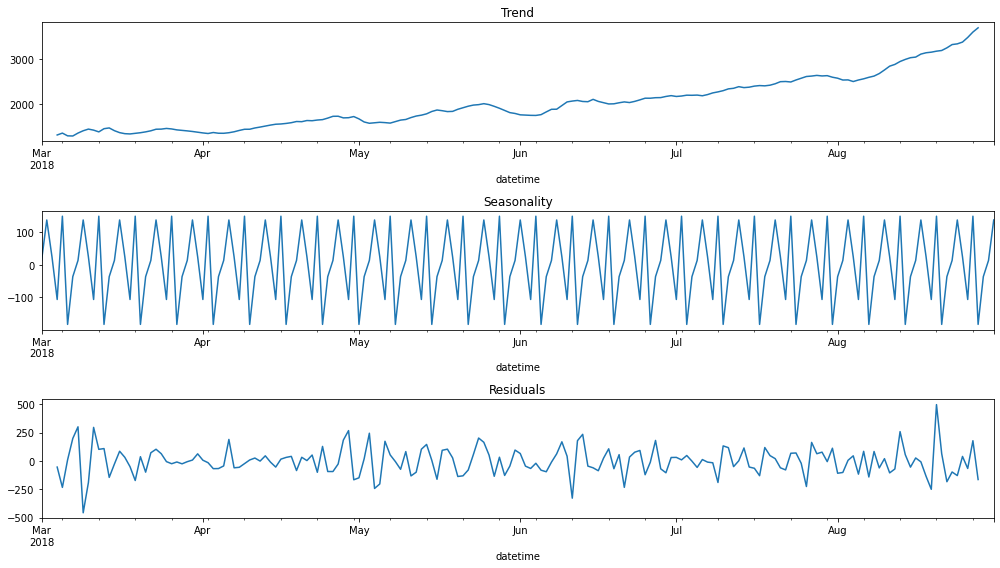

In [65]:
plt.figure(figsize=(14, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

* Тренд — это плавное изменение среднего значения ряда без повторяющихся закономерностей. В нашем случае тренд имеет тенденцию к увеличения количества заказов.
* Сезонность  — циклично повторяющиеся закономерности во временном ряду. Сезонность заказа такси наблюдается в час-пик, либо день недели.
* Остаток - шум, выбросы

Посмотрим данные поближе:

In [66]:
#data_yan = data['2018-01-01':'2018-01-31']
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-30'].resample('1H').sum())

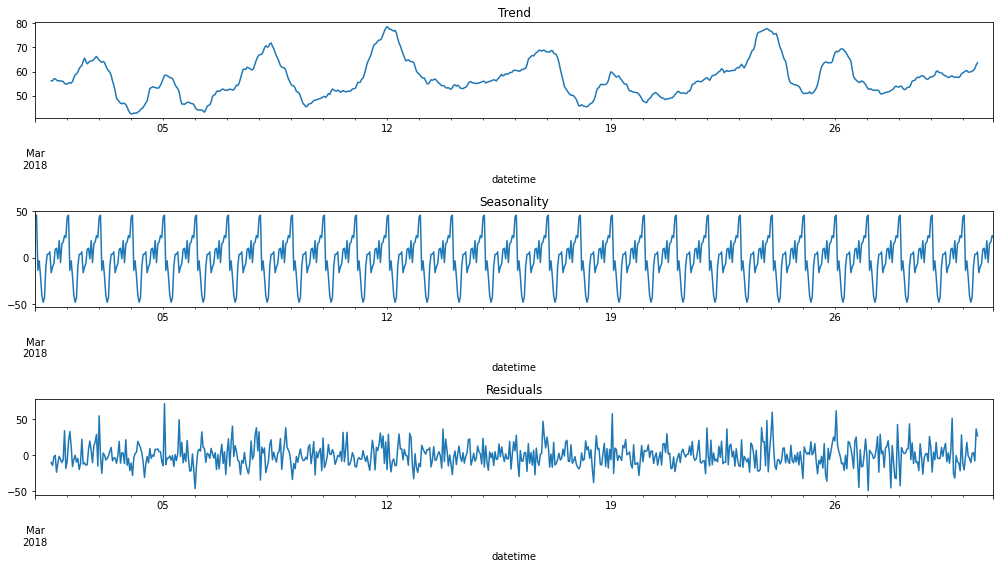

In [67]:
plt.figure(figsize=(14, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Выраженная сезонность от времени суток.

Можно добавить сезонность в признаки.

**Стационарные ряды**

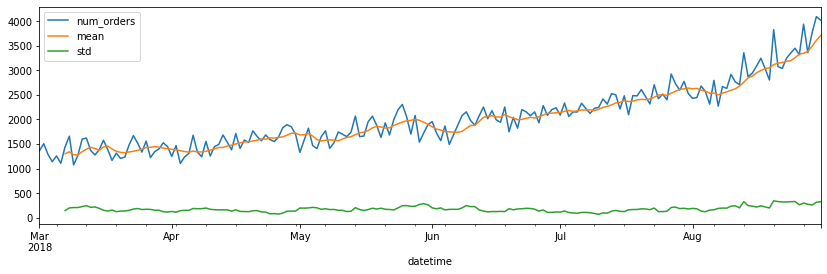

In [68]:
data_std = data.resample('1D').sum()
data_std['mean'] = data_std['num_orders'].rolling(7).mean()
data_std['std'] = data_std['num_orders'].rolling(7).std()
data_std.plot(figsize=(14, 4));

Временной ряд на графике не стационарный, у него меняется среднее значение. Однако, стандартное отклонение не мняется.

Нестационарные ряды прогнозировать сложнее: их свойства меняются слишком быстро. 

**Разности временного ряда**

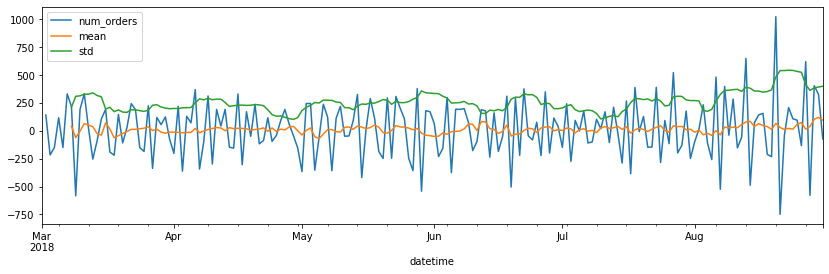

In [69]:
data_r = data.resample('1D').sum()
data_r = data_r - data_r.shift()
data_r['mean'] = data_r['num_orders'].rolling(7).mean()
data_r['std'] = data_r['num_orders'].rolling(7).std()
data_r.plot(figsize=(14, 4));

Разности временного ряда — это набор разностей между соседними элементами временного ряда, т.е. из каждого значения вычитается предыдущее.

Данный график нам показывает динамику изменения цены инструмента во времени. Мы сгруппировали данные за день, установили окно расчета 7 дней.
* медиана количества заказов в сутки наиболее стабильный показатель, значения расположены на нулевой линии
* стандартное отклонение всегда выше нуля, соответственно имеет рост, в конце августа значения выросли почти в 2 раза. А как мы видели ранее, именно во 2 половине августа количество вызовов в час достигали значений свыше 300. 


Напишем функцию для создания дополнительных признаков:

In [70]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month # месяц
    data['day'] = data.index.day #день
    data['dayofweek'] = data.index.dayofweek #день недели
    data['hour'] = data.index.hour #час
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag) # максимальный размер отставания

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean() #скользящее среднее
    

In [71]:
decomposed = seasonal_decompose(data.resample('1H').sum())
data['seasonal'] = decomposed.seasonal
data.head(5)

,num_orders,seasonal
datetime,,
2018-03-01 00:00:00,124,60.248112
2018-03-01 01:00:00,85,20.177074
2018-03-01 02:00:00,71,28.982743
2018-03-01 03:00:00,66,17.885407
2018-03-01 04:00:00,43,2.791145


Разделим выборки. Установим max_lag = 10, rolling_mean_size = 5 (условно)

In [72]:
make_features(data, 10, 10)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
                
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
    
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']


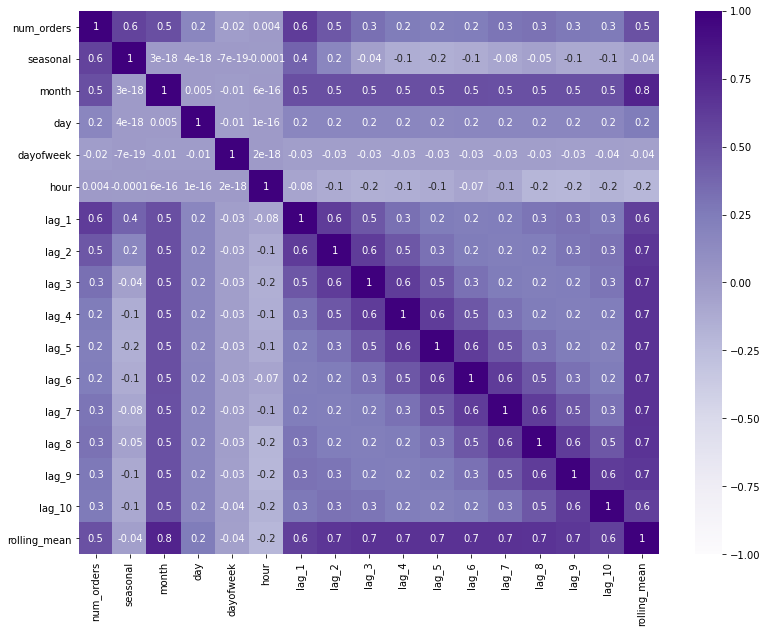

In [73]:
plt.figure(figsize=(13, 10))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, center= 0, cmap= 'Purples', fmt='.1g');

Согласно графику корреляции, на целевой призак сильное влияние оказывают сезонность, месяц, lag_1 (отставание первого порядка), rolling_mean (скользящее среднее).

## Обучение

Мы планируем использовать следующие модели:
- LinearRegression
- RandomForestRegressor
- LGBMRegressor
- Ridge
- ExtraTreesRegressor
- Lasso
- ElasticNetCV

Функция обучения модели:

In [100]:
def ml(model, features, target, params):
    grd = GridSearchCV(estimator = model, param_grid = params, 
                               cv = TimeSeriesSplit(n_splits=3), scoring = 'neg_mean_squared_error')
    grd.fit(features_train, target_train)  
    
    rmse = np.sqrt((-1)*grd.best_score_)
    params_good = grd.best_params_
        
    return rmse, params_good

* GridSearchCV - для подбора гиперпараметров
* TimeSeriesSplit - для кросс-валидации без перемешивания, т.к. для прогнозирования временного радя необходимо соблюдать порядок событий

Выбираем лучшие признаки для каждой модели:

ExtraTreesRegressor

In [101]:
%%time
est = [100, 120, 150, 180, 200]
depth = range(10, 20)

params = {'n_estimators': est, 'max_depth': depth}
rmse, params_good = ml(ExtraTreesRegressor(), features_train, target_train, params)

print(F'rmse = {rmse: ,.2f}')
print(params_good)

rmse =  25.03
{'max_depth': 18, 'n_estimators': 180}
CPU times: user 1min 59s, sys: 666 ms, total: 2min
Wall time: 2min 1s


LinearRegression

In [102]:
%%time
params = {'fit_intercept':[True,False]}
rmse, params_good = ml(LinearRegression(), features_train, target_train, params)

print(F'rmse = {rmse: ,.2f}')
print(params_good)

rmse =  25.31
{'fit_intercept': False}
CPU times: user 260 ms, sys: 351 ms, total: 611 ms
Wall time: 581 ms


Ridge

In [103]:
%%time

alpha = [0.1, 0.3, 0.5, 0.7, 1, 2, 5]

params = {'alpha': alpha}

rmse, params_good = ml(Ridge(), features_train, target_train, params)

print(F'rmse = {rmse: ,.2f}')
print(params_good)

rmse =  25.77
{'alpha': 0.1}
CPU times: user 487 ms, sys: 668 ms, total: 1.15 s
Wall time: 1.18 s


Lasso

In [104]:
%%time

alpha = [0.1, 0.3, 0.5, 0.7, 1, 2, 5]

params = {'alpha': alpha}

rmse, params_good = ml(Lasso(), features_train, target_train, params)

print(F'rmse = {rmse: ,.2f}')
print(params_good)

rmse =  25.90
{'alpha': 0.1}
CPU times: user 1.45 s, sys: 2.1 s, total: 3.55 s
Wall time: 3.59 s


ElasticNetCV

In [105]:

%%time
params = {'l1_ratio': [0.1, 0.3, 0.5, 0.7, 1]}
rmse, params_good = ml(ElasticNetCV(), features_train, target_train, params)

print(F'rmse = {rmse: ,.2f}')
print(params_good)

rmse =  26.07
{'l1_ratio': 1}
CPU times: user 4.98 s, sys: 6.12 s, total: 11.1 s
Wall time: 11.1 s


LGBMRegressor

In [ ]:
%%time

est = [100, 110] # проверено [20, 30, 50, 70, 100, 110, 150]
depth = range(17, 19) # проверено range(10, 20)
boos_type = ['gbdt'] # проверено ['gbdt', 'dart', 'goss']

params = {'n_estimators': est, 'max_depth': depth, 'boosting_type': boos_type}

rmse, params_good = ml(LGBMRegressor(), features_train, target_train, params)

print(F'rmse = {rmse: ,.2f}')
print(params_good)

RandomForestRegressor

In [107]:
%%time

est = [20, 50, 70, 100, 110, 150]
depth = range(10, 20)

params = {'n_estimators': est, 'max_depth': depth}

rmse, params_good = ml(RandomForestRegressor(), features_train, target_train, params)

print(F'rmse = {rmse: ,.2f}')
print(params_good)

rmse =  26.38
{'max_depth': 15, 'n_estimators': 100}
CPU times: user 3min 8s, sys: 764 ms, total: 3min 8s
Wall time: 3min 8s


**Вывод:** В результате перебора признаков и гиперпараметров мы получили следующие результаты:
- модель ExtraTreesRegressor: rmse =  25.05 (max_depth - 13,  n_estimators - 200)
- модель LinearRegression: rmse =  25.31 (fit_intercept - False)
- модель Ridge: rmse =  25.77 (alpha - 0.1)
- модель Lasso: rmse =  25.90 (alpha - 0.1)
- модель ElasticNetCV: rmse =  26.07 (l1_ratio - 1)
- модель LGBMRegressor: rmse =  26.10 (boosting_type - 'gbdt', max_depth - 18, n_estimators - 100)
- модель RandomForestRegressor: rmse =  26.42 (max_depth - 16, n_estimators - 100)

## Тестирование

Протестируем модели на тестовой выборке:
- LinearRegression
- RandomForestRegressor
- LGBMRegressor
- Ridge
- ExtraTreesRegressor
- Lasso
- ElasticNetCV

Мы специально оставили все модели, что бы посмотреть результаты предсказаний тестовой выборки на графике. 

In [108]:
def ml_predict(model, x_features, x_target, y_features, y_target):
    
    model.fit(x_features, x_target)
    predict = model.predict(y_features)
    rmse = mean_squared_error(predict, y_target, squared = False)
    return rmse, predict

In [109]:
%%time
model = ExtraTreesRegressor(max_depth=13,  n_estimators=200)
rmse, predict = ml_predict(model, features_train, target_train, features_test, target_test)
print(F'rmse = {rmse: ,.2f}')

rmse =  40.85
CPU times: user 1.65 s, sys: 8.31 ms, total: 1.65 s
Wall time: 1.66 s


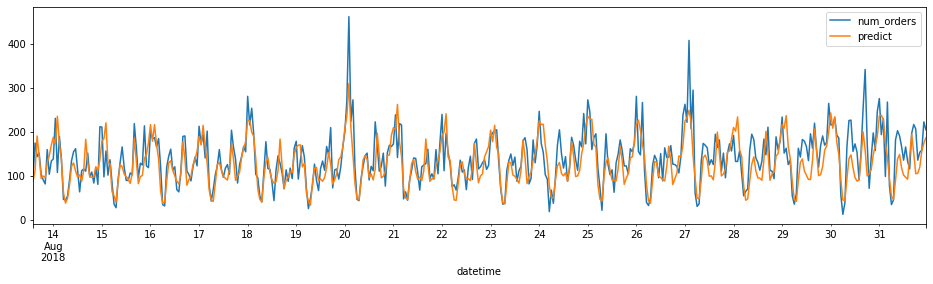

In [110]:
df_etr = pd.DataFrame(target_test)
df_etr['predict'] = predict
df_etr.plot(figsize=(16, 4));

In [111]:
%%time
model = LinearRegression(fit_intercept = False)
rmse, predict = ml_predict(model, features_train, target_train, features_test, target_test)
print(F'rmse = {rmse: ,.2f}')

rmse =  45.57
CPU times: user 14.8 ms, sys: 7.82 ms, total: 22.6 ms
Wall time: 9.68 ms


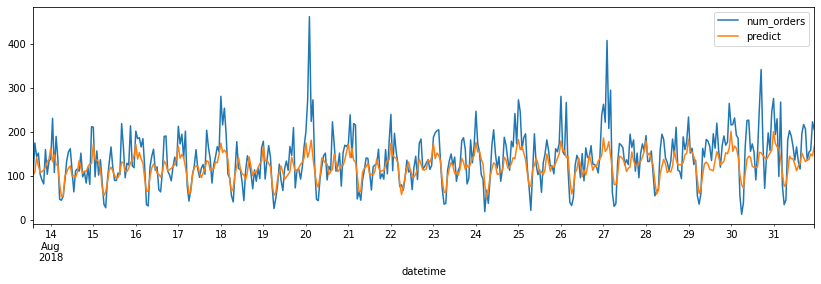

In [112]:
df_lr = pd.DataFrame(target_test)
df_lr['predict'] = predict
df_lr.plot(figsize=(14, 4));

In [113]:
%%time
model = Ridge(alpha=0.1)
rmse, predict = ml_predict(model, features_train, target_train, features_test, target_test)
print(F'rmse = {rmse: ,.2f}')

rmse =  46.13
CPU times: user 16.1 ms, sys: 127 µs, total: 16.2 ms
Wall time: 33 ms


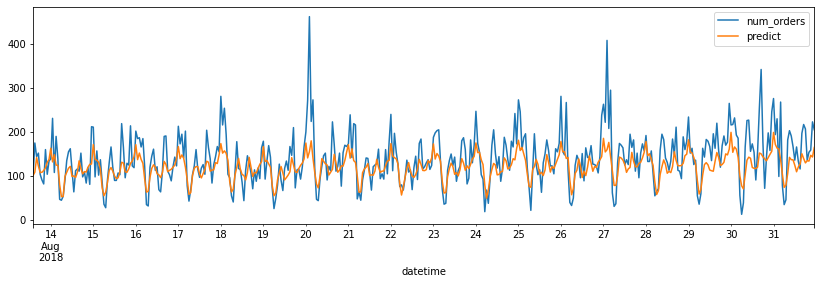

In [114]:
df_rid = pd.DataFrame(target_test)
df_rid['predict'] = predict
df_rid.plot(figsize=(14, 4));

In [115]:
%%time
model = Lasso(alpha=0.1)
rmse, predict = ml_predict(model, features_train, target_train, features_test, target_test)
print(F'rmse = {rmse: ,.2f}')

rmse =  46.12
CPU times: user 104 ms, sys: 145 ms, total: 248 ms
Wall time: 202 ms


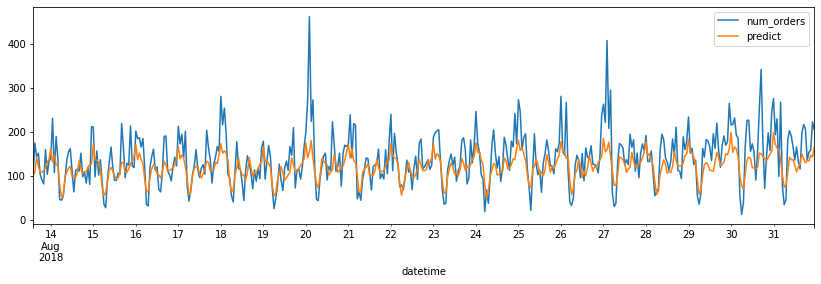

In [116]:
df_las = pd.DataFrame(target_test)
df_las['predict'] = predict
df_las.plot(figsize=(14, 4));

In [117]:
%%time
model = ElasticNetCV(l1_ratio=1)
rmse, predict = ml_predict(model, features_train, target_train, features_test, target_test)
print(F'rmse = {rmse: ,.2f}')

rmse =  46.09
CPU times: user 289 ms, sys: 313 ms, total: 602 ms
Wall time: 578 ms


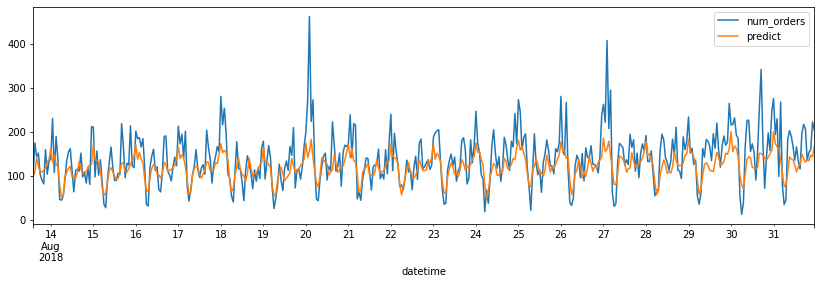

In [118]:
df_enc = pd.DataFrame(target_test)
df_enc['predict'] = predict
df_enc.plot(figsize=(14, 4));

In [119]:
%%time
model = LGBMRegressor(n_estimators=100, max_depth=18, boosting_type='gbdt')
rmse, predict = ml_predict(model, features_train, target_train, features_test, target_test)
print(F'rmse = {rmse: ,.2f}')

rmse =  40.72
CPU times: user 4min 18s, sys: 2.54 s, total: 4min 20s
Wall time: 4min 22s


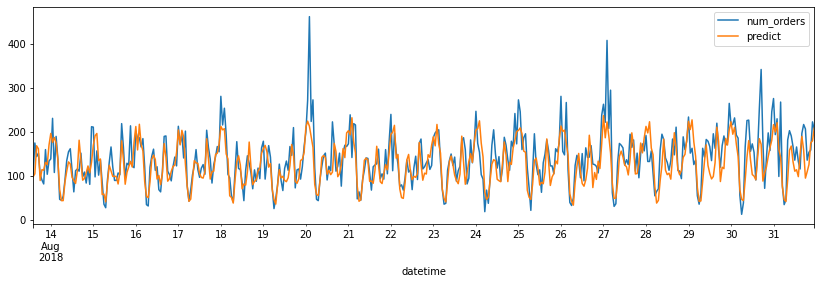

In [120]:
df_lgbmr = pd.DataFrame(target_test)
df_lgbmr['predict'] = predict
df_lgbmr.plot(figsize=(14, 4));

In [121]:
%%time
model = RandomForestRegressor(n_estimators=16, max_depth=100)
rmse, predict = ml_predict(model, features_train, target_train, features_test, target_test)
print(F'rmse = {rmse: ,.2f}')

rmse =  41.06
CPU times: user 448 ms, sys: 4 ms, total: 452 ms
Wall time: 460 ms


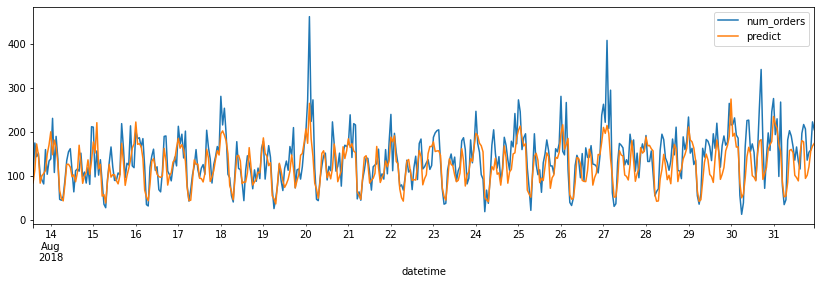

In [122]:
df_rfr = pd.DataFrame(target_test)
df_rfr['predict'] = predict
df_rfr.plot(figsize=(14, 4));

Эталонная модель для сравнения результатов:

In [123]:
%%time
model = DummyRegressor()
rmse, predict = ml_predict(model, features_train, target_train, features_test, target_test)
print(F'rmse = {rmse: ,.2f}')

rmse =  84.70
CPU times: user 3.59 ms, sys: 55 µs, total: 3.64 ms
Wall time: 2.49 ms


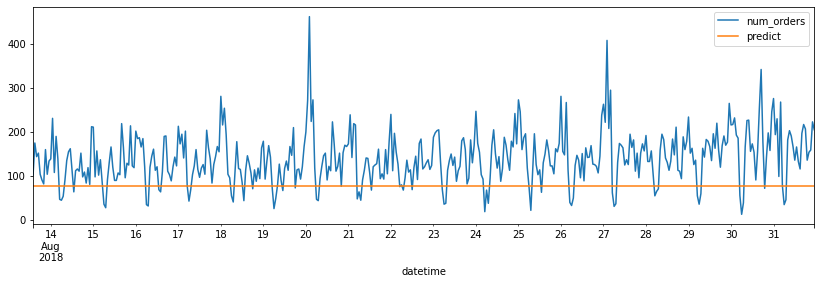

In [124]:
df_dr = pd.DataFrame(target_test)
df_dr['predict'] = predict
df_dr.plot(figsize=(14, 4));

Вывод: **В результате тестирования лучший результат rmse =  40.72 показала модель LGBMRegressor** (boosting_type - 'gbdt', max_depth - 18, n_estimators - 100). 

## Выводы

Нам предоставлен датафрейм, содержащий 26496 наблюдений и два признака (количество заказов и время). В процессе ознакомпления:
* установили 'datetime' в качестве индекса
* отсортировали по возрастанию временного ряда
* провели ресемплирование (группирование) данных а рамках одного часа

У нас имеется 4416 наблюдений. Среднее количество заказов в час 84.42, медиана - 78.0, стандартное отклонение 45.02. На диаграмме размаха заметны выбросы, часы, когда количество заказов превышало 300. Все эти выбросы приходятся на вторую часть августа, и попадут в тестовую выборку. Именно поэтому  мы их удалять не будем, сравним с предсказанными данными.

Скользящее среднее показывает среднее значение цены инструмента (количество заказов) за некоторый период времени (окно). Так как расчет производится на данных, ресемплированных на один день, диапазон расчета скользящего среднего (окно) установили 7 дней. Такие параметры позволяют посмотреть усредненные данные за "скользящую" неделю. По графику можно отметить постепенный рост количества заказов, который усиливается в конце августа.

* Тренд — это плавное изменение среднего значения ряда без повторяющихся закономерностей. В нашем случае тренд имеет тенденцию к увеличения количества заказов.
* Сезонность  — циклично повторяющиеся закономерности во временном ряду. Сезонность заказа такси могла бы проявитья в час-пик, либо день недели.
* Остаток - шум, выбросы

Временной ряд на графике не стационарный, у него меняется среднее значение. Однако, стандартное отклонение не мняется.

Данный график нам показывает динамику изменения цены инструмента во времени. Мы сгруппировали данные за день, установили окно расчета 7 дней.
* медиана количества заказов в сутки наиболее стабильный показатель, значения расположены на нулевой линии
* стандартное отклонение всегда выше нуля, соответственно имеет рост, в конце августа значения выросли почти в 2 раза. А как мы видели ранее, именно во 2 половине августа количество вызовов в час достигали значений свыше 300. 

Мы планируем использовать следующие модели:
- LinearRegression
- RandomForestRegressor
- LGBMRegressor
- Ridge
- ExtraTreesRegressor
- Lasso

Добавили дополнительные признаки, в том числе день недели, месяц, число месяца, сезонность, lag_1 (отставание первого порядка), скользящее среднее.
Согласно графику корреляции, на целевой призак сильное влияние оказывают сезонность, месяц, lag_1 (отставание первого порядка), rolling_mean (скользящее среднее).

 Установили max_lag = 10, rolling_mean_size = 5 (условно)

В результате перебора признаков и гиперпараметров мы получили следующие результаты:
- модель ExtraTreesRegressor: rmse =  25.05 (max_depth - 13,  n_estimators - 200)
- модель LinearRegression: rmse =  25.31 (fit_intercept - False)
- модель Ridge: rmse =  25.77 (alpha - 0.1)
- модель Lasso: rmse =  25.90 (alpha - 0.1)
- модель ElasticNetCV: rmse =  26.07 (l1_ratio - 1)
- модель LGBMRegressor: rmse =  26.10 (boosting_type - 'gbdt', max_depth - 18, n_estimators - 100)
- модель RandomForestRegressor: rmse =  26.42 (max_depth - 16, n_estimators - 100)

4. В результате тестирования лучший результат rmse = 40.72 показала модель LGBMRegressor (boosting_type - 'gbdt', max_depth - 18, n_estimators - 100)